In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.style as style
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import xgboost as xgb

%matplotlib inline

In [14]:
# Memory reduction for importing the dataset
df = data = pd.read_csv('data/criteo-uplift-v2.1.csv',
                   dtype={'f0': 'float32',
                          'f1': 'float32',
                          'f2': 'float32',
                          'f3': 'float32',
                          'f4': 'float32',
                          'f5':'float32',
                          'f6': 'float32',
                          'f7': 'float32',
                          'f8': 'float32',
                          'f9': 'float32',
                          'f10': 'float32',
                          'f11': 'float32',
                          'treatment': 'int8',
                          'conversion': 'int8',
                          'visit': 'int8',
                          'exposure':'int8'})

In [15]:
df.shape

(13979592, 16)

In [16]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616364,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616364,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616364,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616364,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616364,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [17]:
data.isnull().sum()

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

<ipython-input-18-793de1e86eab>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df.corr(), dtype=np.bool)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 [Text(0, 0.5, 'f0'),
  Text(0, 1.5, 'f1'),
  Text(0, 2.5, 'f2'),
  Text(0, 3.5, 'f3'),
  Text(0, 4.5, 'f4'),
  Text(0, 5.5, 'f5'),
  Text(0, 6.5, 'f6'),
  Text(0, 7.5, 'f7'),
  Text(0, 8.5, 'f8'),
  Text(0, 9.5, 'f9'),
  Text(0, 10.5, 'f10'),
  Text(0, 11.5, 'f11'),
  Text(0, 12.5, 'treatment'),
  Text(0, 13.5, 'conversion'),
  Text(0, 14.5, 'visit'),
  Text(0, 15.5, 'exposure')])

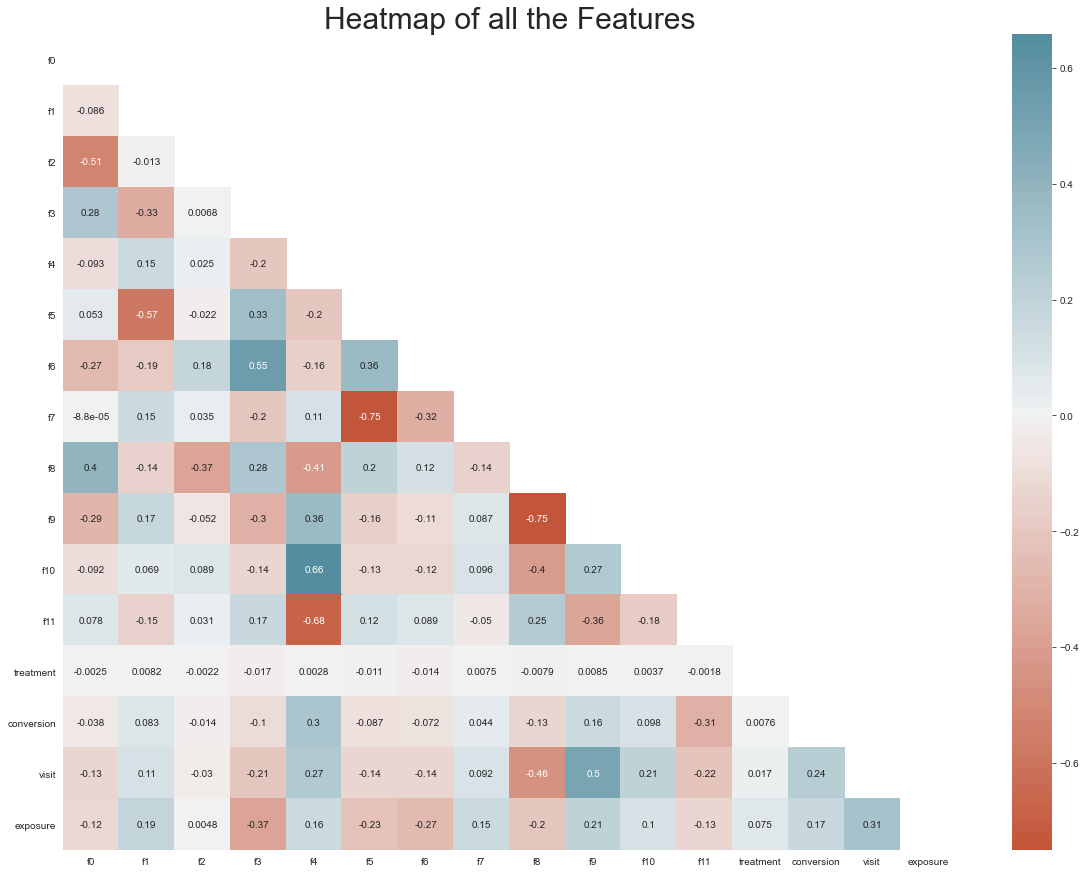

In [18]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (20,15))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(df.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
plt.title("Heatmap of all the Features", fontsize = 30)
plt.yticks(rotation=0)
# plt.savefig('images/heatmap.png')

In [32]:
print('Percentage of users that visit: {}%'.format(100*round(df['visit'].mean(),4)))
print('Percentage of users that convert: {}%'.format(100*round(df['conversion'].mean(),4)))
print('Percentage of visitors that convert: {}%'.format(100*round(df[df["visit"]==1]["conversion"].mean(),4)))

Percentage of users that visit: 4.7%
Percentage of users that convert: 0.29%
Percentage of visitors that convert: 6.21%


In [33]:
vis_results_df = df.groupby('treatment').agg({'visit':['mean', 'sum', 'count']})
vis_results_df

visit                    
               mean       sum     count
treatment                              
0          0.038201   80105.0   2096937
1          0.048543  576824.0  11882655

In [34]:
con_results_df = df.groupby('treatment').agg({'conversion':['mean', 'sum', 'count']})
con_results_df

conversion                   
                mean      sum     count
treatment                              
0           0.001938   4063.0   2096937
1           0.003089  36711.0  11882655

In [35]:
print(f'Difference in clickthrough rate between control and treatment: {np.round(df.groupby("treatment")["visit"].mean()[1] - df.groupby("treatment")["visit"].mean()[0], 4)}')
print(f'Difference in conversion between control and treatment: {np.round(df.groupby("treatment")["conversion"].mean()[1] - df.groupby("treatment")["conversion"].mean()[0], 4)}')

Difference in clickthrough rate between control and treatment: 0.0103
Difference in conversion between control and treatment: 0.0012


In [36]:
proportions_ztest(count=vis_results_df[('visit', 'sum')],
                  nobs=vis_results_df[('visit', 'count')])[1]

0.0

In [37]:
proportions_ztest(count=con_results_df[('conversion', 'sum')],
                  nobs=con_results_df[('conversion', 'count')])[1]

7.30826328583868e-179

### Uplifting
The goal of uplifting is to build a treament (ad) that will work in getting those customers to purchase and/or visit more than a control group. A typical starting point is to build a control dataset that is full of data from a randomized, controlled experiment that represents all customers from all backgrounds (areas of each column of data) from both receiving and not receiving the treatment. If the proportion of customers making a purchase is significantly higher in the treatment group than in the control group it can be concluded that the treatment (promotion/ad) is working since it encourages a purchase across all customers. This is called the average treatment effect (ATE). Quantifying this ATE level is the goal of a typical A/B test.

In this case we can conclude that the promtion was statistically significant and is likely sucessful in encouraging people to purchase the product. The p-value is <0.05 for both, so we know the ATE is significant - which is the typical starting point for uplift modeling and statistical work in general.

It is worth pointing out that there is another variable called 'exposure' which indicates whether a treatment was properly exposed to the user. This is important because a user that is treated might still carry out an desired action (clicking, purchasing etc..) without actually being influenced by the treatment. It would be interesting to see whether there is a big differences in outcomes depending on whether a user was effectively exposed.

In [41]:
df[df['treatment']==1]['exposure'].value_counts(normalize = True)

0    0.963963
1    0.036037
Name: exposure, dtype: float64

Only 3.6% or 1 out of every 28 users in our treatment group were effectively exposed to the treatment, suggesting the treatment is very ineffective at capturing the attention of the users.

How does the number of users that visit and convert differ between treated users that were exposed, and those that were not?

In [43]:
vis_exp_results_df = df[df['treatment']==1].groupby('exposure').agg({'visit':['mean', 'sum', 'count']})
vis_exp_results_df

visit                    
              mean       sum     count
exposure                              
0         0.034861  399314.0  11454443
1         0.414538  177510.0    428212

In [44]:
con_exp_results_df = df[df['treatment']==1].groupby('exposure').agg({'conversion':['mean', 'sum', 'count']})
con_exp_results_df

conversion                   
               mean      sum     count
exposure                              
0          0.001194  13680.0  11454443
1          0.053784  23031.0    428212

In [46]:
proportions_ztest(count=vis_exp_results_df[('visit', 'sum')],
                  nobs=vis_exp_results_df[('visit', 'count')])[1]

0.0

In [47]:
proportions_ztest(count=con_exp_results_df[('conversion', 'sum')],
                  nobs=con_exp_results_df[('conversion', 'count')])[1]

0.0

There is a substantially higher clickthrough rate for treated users that were exposed (41%) than treated users that were not (3.5%). Similar results were found for conversion, with 5.3% of exposed users converting compared to only 0.12% of treated users that were not . These results, together with the p-value's (<0.5) suggest the intervention is having a significant impact, but is not being exposed to enough people. Lets see if theres any effect not being exposed has on the treatment group.

In [48]:
df[df['exposure']==0].groupby('treatment').agg({'visit':['mean', 'sum', 'count']})

visit                    
               mean       sum     count
treatment                              
0          0.038201   80105.0   2096937
1          0.034861  399314.0  11454443

In [51]:
df['treatment'].value_counts()

1    11882655
0     2096937
Name: treatment, dtype: int64

Class 0: 2096937
Class 1: 11882655
Proportion: 6 : 1


(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '0')])

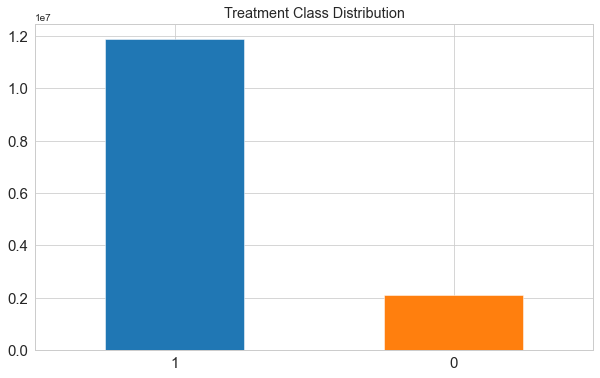

In [56]:
fig = plt.figure(figsize = (10,6))
target_count = df['treatment'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', int(round(target_count[1] / target_count[0])), ': 1')
target_count.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0)

## Resampling

By seeing the distributions we can have an idea how skewed the target variable is - most of the users were in the treatment group. The problem is that many approaches uplift models assume the treatment group and the control group have a balanced distribution, which needs not hold in practice. In this case we may reweight, or resample, the training datasets such that the assumption becomes valid. According to Jaśkowski and Jaroszewicz (2012) resampling the treatment distribution can affect the learning algorithm and result in information loss, however, as long as the algorithm does a reasonably good job at modeling the conditional class distributions, the results will still be meaningful. As our dataset consists of 13M rows, we can be fairly confident any resampled dataset will contain enough instances to provide meaningful results.

Before proceeding with the random undersampling we have to separate the orginal dataframe so that the undersampling is only done on the training dataset. Why? for testing purposes, we want to test our models on a dataset with real life class distributions.

In [57]:
train, test  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['treatment'])

In [59]:
# Random Undersampling (finding the majority class and undersampling it)
def random_under(df:pd.DataFrame, feature):
    
    target = df[feature].value_counts()
    
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1

In [60]:
train = random_under(train, 'treatment')

Class 0: 1677550
Class 1: 1677550
Proportion: 1 : 1


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

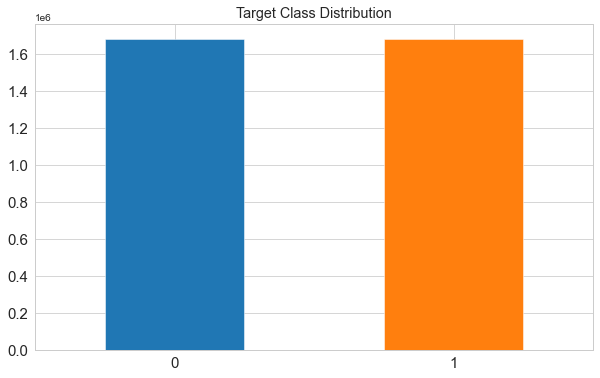

In [61]:
fig = plt.figure(figsize = (10,6))
new_target_count = train['treatment'].value_counts()
print('Class 0:', new_target_count[0])
print('Class 1:', new_target_count[1])
print('Proportion:', int(round(new_target_count[0] / new_target_count[1])), ': 1')
new_target_count.plot(kind='bar', title='Target Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 

As can be seen, the new training dataset has a total of 3,355,100 instances with 50% in the treatment and 50% in the control groups.

## Uplift Modeling
The Uplift model used in this notebook is the Generalized Weighed Uplift (LGWUM) (Kane et al., 2014). LGWUM is one of several methods available for Uplift Modeling, and uses an approach to Uplift Modelling better known as Class Variable Transformation. LGWUM assumes that positive uplift lies in treating treatment-group responders (TR) and control-group non-responders (CN), whilst avoiding treatment-group non-responders (TN) and control-group responders (CR). This is visually shown as:

𝑈𝑝𝑙𝑖𝑓𝑡 𝐿𝐺𝑊𝑈𝑀 = P(TR)/P(T) + P(CN)/P(C) - P(TN)/P(T) - P(CR)/P(C)

In [62]:
# Function to declare Target Class

def target_class(df, treatment, target):
    
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df[treatment] == 0) & (df[target] != 0),'target_class'] = 1 
    #TN:
    df.loc[(df[treatment] != 0) & (df[target] == 0),'target_class'] = 2 
    #TR:
    df.loc[(df[treatment] != 0) & (df[target] != 0),'target_class'] = 3 
    return df

In [63]:
train = target_class(train.drop(columns = ['conversion', 'exposure']), 'treatment', 'visit')
test = target_class(test.drop(columns = ['conversion', 'exposure']), 'treatment', 'visit')

In [66]:
X_train = train.drop(['visit','target_class'],axis=1)
y_train = train['target_class']
X_test = test.drop(['visit','target_class'],axis=1)
y_test = test['target_class']

In [68]:
def uplift_model(X_train,
                 X_test,
                 y_train,
                 y_test,
                 treatment_feature):

    result = pd.DataFrame(X_test).copy()    
    uplift_model = xgb.XGBClassifier().fit(X_train.drop(treatment_feature, axis=1), y_train)
    
    uplift_proba = uplift_model.predict_proba(X_test.drop(treatment_feature, axis=1))
    
    result['p_cn'] = uplift_proba[:,0] 
    result['p_cr'] = uplift_proba[:,1] 
    result['p_tn'] = uplift_proba[:,2] 
    result['p_tr'] = uplift_proba[:,3]
    
    result['uplift_score'] = result.eval('\
    p_cn/(p_cn + p_cr) \
    + p_tr/(p_tn + p_tr) \
    - p_tn/(p_tn + p_tr) \
    - p_cr/(p_cn + p_cr)')  

    # Put the result 
    result['target_class'] = y_test
    
    return result

In [69]:
result = uplift_model(X_train, X_test, y_train, y_test, 'treatment')
result.head()

/Users/jamesjordan/Documents/GitHub/uplift-modeling-criteo-kaggle/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[18:46:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,p_cn,p_cr,p_tn,p_tr,uplift_score,target_class
6304619,21.890358,10.059654,8.214383,4.679882,10.280525,4.115453,-4.595459,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0.501936,0.000273,0.497505,0.000287,0.000066,0
4045638,15.995929,10.059654,8.214383,0.973841,10.280525,4.115453,-7.301017,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.496887,0.001435,0.499149,0.002529,0.004323,2
5767216,19.111923,10.059654,8.214383,3.359763,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0.499098,0.000509,0.498845,0.001547,0.004145,0
9668584,12.870404,10.059654,8.979246,-1.025575,10.280525,4.115453,-16.175537,4.833815,3.902645,13.190056,5.300375,-0.168679,1,0.438020,0.011477,0.523668,0.026835,0.046428,2
830405,21.992620,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.502347,0.000264,0.497207,0.000182,-0.000318,2


Text(0, 0.5, 'Number of observations in validation set')

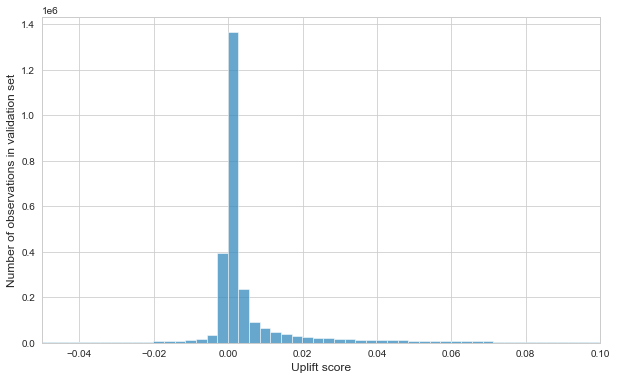

In [75]:
plt.figure(figsize = (10,6))
plt.xlim(-.05, .1)
sns.histplot(data=result, x='uplift_score', bins=1000)
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set')

Overall the uplift distribution is positive indicating that the hypothesis that the treatment sucessfully encourages visits on average. Negative uplift indicates customers that were discouraged from visiting ('sleeping dogs'). These could be the people that had a decreased clickthrough & conversion.

In [85]:
result[result['uplift_score'] > 0].groupby('treatment').agg({'uplift_score': ['mean', 'sum', 'count']})

uplift_score                       
                  mean           sum    count
treatment                                    
0             0.018077   5809.502930   321369
1             0.021655  39589.609375  1828198

In [86]:
def qini_rank(uplift): 
    # Function to Rank the data by the uplift score
    ranked = pd.DataFrame({'ranked uplift':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    ranked['ranked uplift'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking   
    ranked = ranked.sort_values(by='ranked uplift').reset_index(drop=True)
    return ranked

def qini_eval(ranked):
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['ranked uplift'] * uplift_model['uplift'].iloc[-1],5)
    
    uplift_model['Number_of_exposed_customers'] = np.arange(len(uplift_model))+1
    uplift_model['visits_gained'] = uplift_model.uplift*len(uplift_model)
    
    # Add q0
    q0 = pd.DataFrame({'ranked uplift':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='ranked uplift').reset_index(drop = True)
    return merged, uplift_model

In [87]:
def uplift_curve(uplift_model):
    plt.figure(figsize = (10,6))
    # plot the data
    ax = uplift_model['visits_gained'].plot(color=['#2077B4'])
    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Number of customers treated')
    plt.ylabel('Incremental visits')
    plt.grid(b=True, which='major')
    return ax

def qini_plot(merged:pd.DataFrame, uplift_model:pd.DataFrame):
    gain_x = uplift_model['ranked uplift']
    gain_y = uplift_model.uplift
    qini = auc(gain_x, gain_y)
    # plot the data
    plt.figure(figsize = (10,6))
    mpl.rcParams['font.size'] = 8
    qini = auc(gain_x, gain_y)

    ax = plt.plot(gain_x, gain_y, color= '#2077B4',
        label='Normalized Uplift Model, Qini Score: {}'.format(round(qini,2)))
    
    plt.plot([0, gain_x.max()], [0, gain_y.max()],
        '--', color='tab:orange',
        label='Random Treatment')
    plt.legend()
    plt.xlabel('Porportion Targeted')
    plt.ylabel('Uplift')
    plt.grid(b=True, which='major')

    return ax

def plot_uplift(result:pd.DataFrame):
    # Function to plot the uplift curve
    ranked = qini_rank(result)
    merged, uplift_model = qini_eval(ranked)
    ax1 = uplift_curve(uplift_model)
    
    return ax1

In [88]:
def plot_qini(result:pd.DataFrame):
    # Function to plot the qini curve
    ranked = qini_rank(result)
    merged, uplift_model = qini_eval(ranked)
    ax2 = qini_plot(merged, uplift_model)
    
    return ax2 

<AxesSubplot:xlabel='Number of customers treated', ylabel='Incremental visits'>

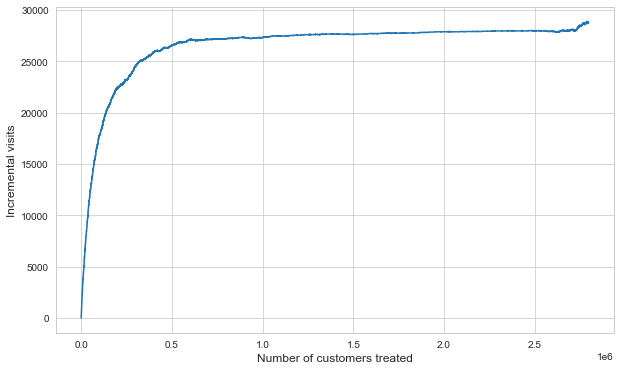

In [89]:
plot_uplift(result)

If we offer the treatment to every customer (2,500,000), we’ll increase the number of visitors by 30,000. However we can achieve a gain of 26,000 customers, about 86% of the maximum possible, by only offering treatment to the top 20% of customers. One advantage of the uplift curve, however, is that similar to the ROC curve, we can calculate an area under the curve, with the interpretation that larger area indicates a better performing model: we would like to be able to gain as many customers as possible, by targeting a few as possible.

Before calculating an AUC, it is better to normalize the data. As shown, the gain curve has units of customers on both the x- and y-axes which can be good for visualizing things in real-world quantities however it makes comparing different models very difficult. We can fix this by scaling the curve so that the axes are between 0 and 1.

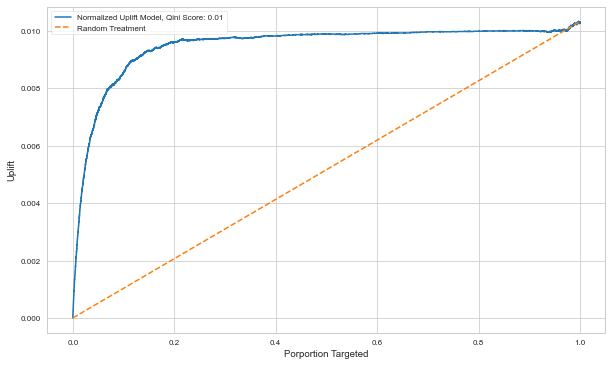

In [90]:
plot_qini(result)

While the model appears to be able to distinguish positive from negative outcomes as shown by its steep initial slope, the Qini-score is only 0.01, suggesting the total incremental positive outcomes from the treatment is low and that actually there is little difference between this treatment and a random targeting strategy.

It is worth considering what impact a user being properly exposed has on their incremental outcomes. This will be explored by calling the pre-defined functions from above while changing the treatment classes to 'exposure'.

Class 0: 13551380
Class 1: 428212
Proportion: 32 : 1


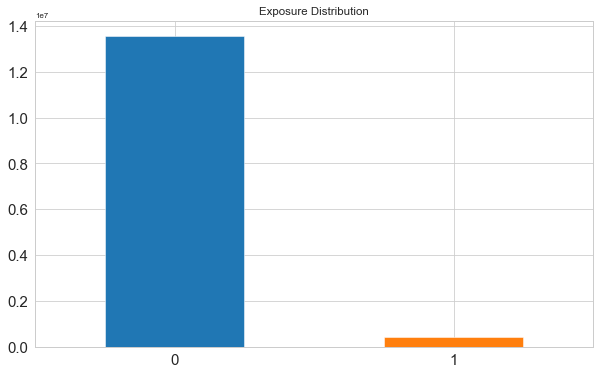

In [91]:
plt.figure(figsize = (10,6))
target_count = df['exposure'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', int(round(target_count[0] / target_count[1])), ': 1')
target_count.plot(kind='bar', title='Exposure Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 
plt.show()

In [92]:
train, test  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['exposure'])
train = random_under(train, 'exposure')

Class 0: 342570
Class 1: 342570
Proportion: 1 : 1


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

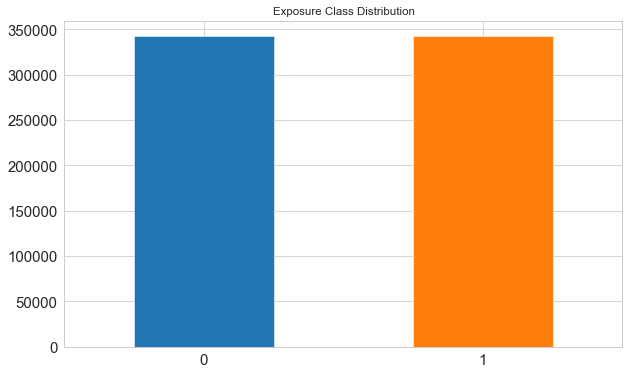

In [93]:
plt.figure(figsize = (10,6))
new_target_count = train['exposure'].value_counts()
print('Class 0:', new_target_count[0])
print('Class 1:', new_target_count[1])
print('Proportion:', int(round(new_target_count[0] / new_target_count[1])), ': 1')
new_target_count.plot(kind='bar', title='Exposure Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 

In [94]:
train = target_class(train.drop(columns = ['conversion', 'treatment']), 'exposure', 'visit')
test = target_class(test.drop(columns = ['conversion', 'treatment']), 'exposure', 'visit')

In [95]:
X_train = train.drop(['visit','target_class'],axis=1)
y_train = train['target_class']
X_test = test.drop(['visit','target_class'],axis=1)
y_test = test['target_class']

In [96]:
result = uplift_model(X_train, X_test, y_train, y_test, 'exposure')

/Users/jamesjordan/Documents/GitHub/uplift-modeling-criteo-kaggle/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[19:09:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(0, 0.5, 'Number of observations in validation set')

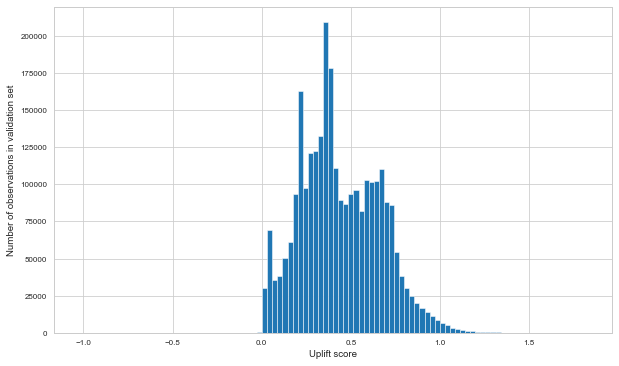

In [97]:
plt.figure(figsize = (10,6))
plt.hist(result.uplift_score, bins=100, color=['#2077B4'])
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set')

The distribution of uplift is almost entirely positive, meaning the treatment almost always encourages individuals to visit when they are properly exposed, and almost never discouraging them.

<AxesSubplot:xlabel='Number of customers treated', ylabel='Incremental visits'>

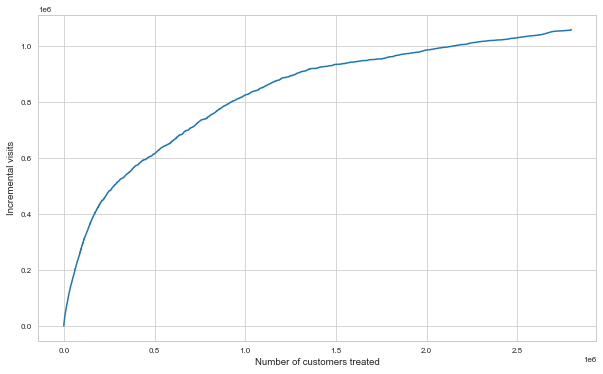

In [98]:
plot_uplift(result)

As can be seen, when users are properly exposed to the treatment, the incremental positive outcomes or uplift is much higher. If we offer the treatment to every customer, we’ll increase the number of visitors by 1,060,000. However we can achieve a gain of 620,000 customers, about 58% of the maximum possible, by only offering treatment to the top 20% of customers. Given the different magnitude of customers, in order to compare this model to our previous one, we must once again normalize our results.

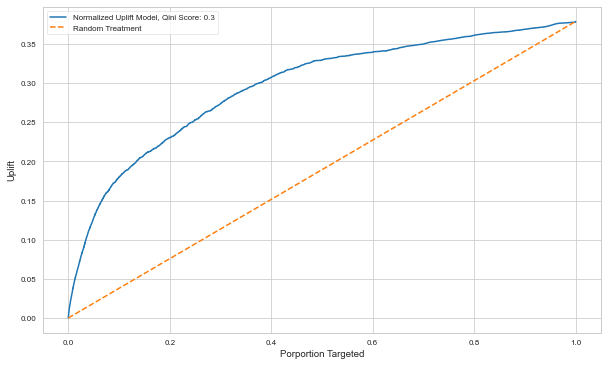

In [99]:
plot_qini(result)

As can be seen, the Qini-score is roughly x29 better than the previous model suggesting the cumulative number of the incremental positive outcomes is much larger providing users are effectively exposed.

## Conclusion
The goal of uplift modeling is to create predictive models of the individual treatment effect. Such models allow data scientists to segment populations into groups that are more likely to respond to treatment, and those that are less so. In this example, the effect of properly exposing users to the treatment is shown to significantly increase the incremental outcomes compared to the normal treatment group. As can be seen the evaluation of uplift models is not as straightforward as that of supervised classification or regression models because it requires separate consideration, and comparison, of treatment and control groups. However, open source Python packages (CausalML, Pylift, Scikit-Uplift), have been created to facilitate uplift model development and evaluation.

Some resources that helped me and I recommend taking a look at if you're interested in finding out more:

Gubela, Robin & Bequé, Artem & Gebert, Fabian & Lessmann, Stefan. (2019). Conversion Uplift in E-Commerce: A Systematic Benchmark of Modeling Strategies. International Journal of Information Technology & Decision Making. 18. 10.1142/S0219622019500172.

Gutierrez, P., & Gérardy, J. Y. (2017, July). Causal Inference and Uplift Modelling: A Review of the Literature. In International Conference on Predictive Applications and APIs (pp. 1-13).

Cheng, L., Leung, A. C. S., & Ozawa, S. (Eds.). (2018). Neural Information Processing. Lecture Notes in Computer Science. doi:10.1007/978-3-030-04221-9

https://www.steveklosterman.com/uplift-modeling/

This notebook adapts some of the functions provided in this notebook: https://www.kaggle.com/arashnic/uplift-modeling